In [ ]:
import os
import h5py
import urllib.request
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/car-damage-dataset.zip"

Archive:  /content/gdrive/MyDrive/car-damage-dataset.zip
   creating: car-damage-dataset/
   creating: car-damage-dataset/data1/
   creating: car-damage-dataset/data1/training/
   creating: car-damage-dataset/data1/training/damage/
  inflating: car-damage-dataset/data1/training/damage/0001.JPEG  
  inflating: car-damage-dataset/data1/training/damage/0002.JPEG  
  inflating: car-damage-dataset/data1/training/damage/0003.JPEG  
  inflating: car-damage-dataset/data1/training/damage/0004.JPEG  
  inflating: car-damage-dataset/data1/training/damage/0005.JPEG  
  inflating: car-damage-dataset/data1/training/damage/0006.JPEG  
  inflating: car-damage-dataset/data1/training/damage/0007.JPEG  
  inflating: car-damage-dataset/data1/training/damage/0008.JPEG  
  inflating: car-damage-dataset/data1/training/damage/0009.JPEG  
  inflating: car-damage-dataset/data1/training/damage/0010.JPEG  
  inflating: car-damage-dataset/data1/training/damage/0011.JPEG  
  inflating: car-damage-dataset/data1/trai

In [ ]:
!unzip "/content/gdrive/MyDrive/car-damage-dataset.zip"

In [ ]:
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.models import Sequential, load_model, Model
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.utils import get_file
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array,load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, History
from tensorflow.keras import Input

In [ ]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [ ]:
vgg16 = VGG16(weights='imagenet')
vgg19 = VGG19(weights='imagenet')
inception = InceptionV3(weights='imagenet')
xception = Xception(weights='imagenet')

91884032/91884032 [==============================] - 1s 0us/step


In [ ]:
def prepare_image_224(img_path):
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def prepare_image_299(img_path):
    img = load_img(img_path, target_size=(299,299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

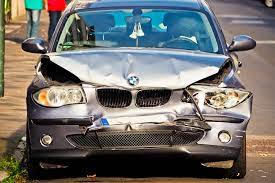

In [ ]:
Image('/content/download.jpg')

TESTING WITH DIFFERENT MODELS ( VGG16,VGG19, ETC)

In [ ]:
y = prepare_image_224('/content/download.jpg')
preds = vgg16.predict(y)
print(get_predictions(preds, top=5))

35363/35363 [==============================] - 0s 1us/step
[[('n03459775', 'grille', 0.272367), ('n02814533', 'beach_wagon', 0.2041221), ('n03770679', 'minivan', 0.09470775), ('n02930766', 'cab', 0.0932334), ('n03930630', 'pickup', 0.07585643)]]


In [ ]:
z = prepare_image_224('/content/download.jpg')
preds = vgg19.predict(z)
print(get_predictions(preds, top=5))

1/1 [==============================] - 1s 954ms/step
[[('n03770679', 'minivan', 0.25708997), ('n03459775', 'grille', 0.17301686), ('n02930766', 'cab', 0.1465025), ('n02814533', 'beach_wagon', 0.047712997), ('n03930630', 'pickup', 0.04145035)]]


VGG 16 SHOWS BEST ACCURACY
BUILIDNG PIPELINE


In [ ]:
def get_car_categories():
    d = defaultdict(float)
    img_list = os.listdir('car-damage-dataset/data1/training/whole')
    for i, img_path in enumerate(img_list):
        img = prepare_image_224('car-damage-dataset/data1/training/whole/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out,top=5)
        for pred in preds[0]:
            d[pred[0:2]]+=pred[2]
        if(i%50==0):
            print(i,'/',len(img_list),'complete')
    return Counter(d)

In [ ]:
categ_count = get_car_categories()

1/1 [==============================] - 1s 977ms/step
0 / 920 complete
1/1 [==============================] - 1s 618ms/step
50 / 920 complete
1/1 [==============================] - 1s 587ms/step
100 / 920 complete
1/1 [==============================] - 1s 683ms/step
150 / 920 complete
1/1 [==============================] - 1s 1s/step
200 / 920 complete
1/1 [==============================] - 1s 614ms/step
250 / 920 complete
1/1 [==============================] - 1s 581ms/step
300 / 920 complete
1/1 [==============================] - 1s 1s/step
350 / 920 complete
1/1 [==============================] - 1s 971ms/step
400 / 920 complete
1/1 [==============================] - 1s 593ms/step
450 / 920 complete
1/1 [==============================] - 1s 622ms/step
500 / 920 complete
1/1 [==============================] - 1s 1s/step
550 / 920 complete
1/1 [==============================] - 1s 603ms/step
600 / 920 complete
1/1 [==============================] - 1s 622ms/step
650 / 920 complete
1/1 

In [ ]:
with open('vgg16_cat_list.pk', 'wb') as f:
    pk.dump(categ_count, f, -1)

In [ ]:
with open('vgg16_cat_list.pk', 'rb') as f:
    categ_count = pk.load(f)

In [ ]:
categ_list = [k for k, v in categ_count.most_common()[:50]]

In [ ]:
def get_car_categories(categ_list):
    img_list = os.listdir('car-damage-dataset/data1/training/whole')
    n = 0
    bad_list = []
    for i, img_path in enumerate(img_list):
        img = prepare_image_224('car-damage-dataset/data1/training/whole/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out, top=5)
        for pred in preds[0]:
            if pred[0:2] in categ_list:
                n+=1
                break
            else:
                pass
            bad_list.append(img_path)
        if i%100 == 0:
            print(i,'/',len(img_list), 'complete')
    bad_list = [k for k, v in Counter(bad_list).items() if v == 5]
    return n, bad_list

In [ ]:
num, bad_list = get_car_categories(categ_list)

1/1 [==============================] - 1s 646ms/step
0 / 920 complete
1/1 [==============================] - 1s 664ms/step
100 / 920 complete
1/1 [==============================] - 1s 972ms/step
200 / 920 complete
1/1 [==============================] - 1s 624ms/step
300 / 920 complete
1/1 [==============================] - 1s 618ms/step
400 / 920 complete
1/1 [==============================] - 1s 907ms/step
500 / 920 complete
1/1 [==============================] - 1s 642ms/step
600 / 920 complete
1/1 [==============================] - 1s 604ms/step
700 / 920 complete
1/1 [==============================] - 1s 633ms/step
800 / 920 complete
1/1 [==============================] - 1s 1s/step
900 / 920 complete
1/1 [==============================] - 1s 613ms/step


In [ ]:
def pipe1(img_path, categ_list):
    urllib.request.urlretrieve(img_path, 'image.jpg')
    img = prepare_image_224('image.jpg')
    out = vgg16.predict(img)
    preds = get_predictions(out, top=5)
    print("Ensuring entered picture is a car...")
    for pred in preds[0]:
        if pred[0:2] in categ_list:
            print(pred[0:2])
            return "The inputed picture is of a Car"
    return "The entered image is a not a car. Please try again. Consider a different angle or lighting."

In [ ]:
pipe1("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgKCgkLDRYPDQwMDRsUFRAWIB0iIiAdHx8kKDQsJCYxJx8fLT0tMTU3Ojo6Iys/RD84QzQ5OjcBCgoKDQwNGg8PGjclHyU3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3N//AABEIAHUA0AMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAABAEDBQYHAgj/xABCEAABAwMCAwUFBQQHCQAAAAABAAIDBAUREiEGEzEiQVFhcQcUMoGRQlKhscEVI2KCFjNTY7LC8QgkJTRDVXJzov/EABkBAQADAQEAAAAAAAAAAAAAAAACAwQBBf/EACIRAQACAgMAAgIDAAAAAAAAAAABAgMREiExEyJBYQQyUf/aAAwDAQACEQMRAD8A7iiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiLy86Rk9O9BUlYq6X6it2WyOdJL/AGUQDnenqtP4l4wraqokpLI5sNMw6X1Tt3SHwYO4bjfzC5/cHOqZZdRfM1p5Y175wdye7Oc/gr6YZt6pyZorHTpVT7RYaYSOqqMUrQ3UwyzfH4g7dk4zjqDjCuD2qcJf9xx/KuQ1jddqkaG4bG8jp3EDP5fitFL3McWOPaacHJVmTFSmv2hTJa0Pp2P2ncJydLo1vqFNg494Wm+G90YP8cgb+a+W45ndxU+lrXswASquNHZveH1NFxHZZY+ZFdKSRviyUO/JSaO626uJFHW087hsRHIHEeoXzjQ3V9O5olDemd91utrudNIWSSRsL9iJG5Y4fzNIK78UT45GeY9h2TIKqtQtd+liaMufWQbZGczMHl/aD/6/8itnpKyCsgbNSytlidnDmnw2I9VVasx6vreLeJCIiikIiICIiAiIgIiICIiAiIgLWuNLhUQWhzLfD7zM92lzGkbDB6+WcZ8lO4rurLPw/XVrnYeyFwiGcF0hHZaPMnC4TbOKa2w8pkokqInxh/KnmcRqPVw223BV+HFz7U5r8Y1DZK2nqqWiLaeGaafo18bNRz1c7wyTn6rn13jvlLI+Sogq4oQ/Q2SXLQTjYbOIW9j2hwMLJZ7eeXKzI5c2XZHXqMbdMKPduMrBdLdNTVVvq5WuGWxuc1uXDdvaByN/BbdWj+sssTr2EJrWTW2CjDmvllY50j9WdGcEEgb9AOgPVa7Jw48vkaypiec5A5Eud/5VuHBFJV01G2rprdbJopmBr3RzkTtA23GDjpnB6+Ky9XcaQMcKiGaF3TfS4Dz6qyuOt66t3pCck1t05eeE7jjsRiT01D82qy/h+4wka6WQb9c7fiF1n37g+qDTVUtVTHHbMMhIB8t8n6KI6l4Qmlmii4lqKfVl0L5Wva1m3wu1AZ3Pj3LPNMUT3EtETb9Of09kvFY5rKeie97fNrM+hcRn5LLUtm4kpmhotjnEdxqIh/mWUqbPTvpnTW/im2VEjCNcMjgw9Ny06tx9FaoLHxPcqCOstlRBUwPBxidwwQcEbjqCCu1pinyXJi3+JVCeJ6UjmWWR7QB/VVEbz9AVsdBfqyjkfUGkrqOrd8fMo5HxzeGsNB3x0cNx5jZc6vVbxBYJ2Q3aB8DntLmOMgc1wBwcEZHy6qLHxjcmYGqQeAD+vpsk1xeTZGK39iHbeHeP6askqIb42K2PhAIlmk0RyemrHgtipeJLHWf8peLfP/6qpjv1XArdxtfKmQw0sNTO8NLy1h1ENAySQr0PHolkZJU2qCoeztNc6JjnDzacZ8NwqbYcUz1aF0ZMkR4+imvDgHNIIPQgqq5RwxxpW36pdTWygmNTEzWWMqQxgbnGT2SMZ+a6PaKt88T453xPngIbK6J2WkloP6rPenGfVtb8vwyKIigmIiICIiAiIgIiIOPf7QN39yFjpAC5sjppXgOwRgNa0+nad9FyqrkMoY8EuGF1j24WyV934ducOwZzYnOLdQa4APb2e/OHfguUTlraqVrG4jLstHgDuB8gVpwW9hRmj8ovMHoSq6/Dr4q5JE0ns/RRyHMdpAyTsAN8q6dxCqNTKXRXSippnc188cozoliAGk47z16+C3W18UU80cEN8iNRTvGltSzeRh/i+8MfP1XOpqClpMtr6p3vP24YQDyz4Fx2J8QM48VepJGspjFFI5zGuy3UNx9PmqsOW1b72syY4mrot/4ciFF+0LbWRVFMQXB7HZHmD4HyWl0k1TOHPpIamZjRlxihc8AeeAcLz+1KiKgqIYZntErCHNaTh23es5BUW2xUFG62X23VMssrGSNMZe+Jp2LhsNOMnrnotv8AI/kTXjpTgxzrtimVTZew8EuHUd4+RVYqmOGXmQVckL8/FGXNP1C98V2w2/3KaO+Ulzlmy3EDgXMPXO3dv3qHPGX0/NmaIqlnxMO2sDvHmu4s3yV7hK1eMpFdxXfJYGUVwq46+EO1NbVRtlaCPhdlw7x+ihftePmP/wCGWgtb3upGAnbuxhRpRz4miMjmMGMZHbZ4eo6hRSzfBLtDfgbjcHzXl3pNbTDTWYmG1WHi2KiikZNbo2Md2w2ixHkjoXNJ65GzmuDh1HeFjn33mTTOFstbzqL9U9PzXuBJOC4/EfksVE0h0hcXGTbXj7QzvjzVWxSaGgOc0tGYnDUdHlsOqi702ah4vu7eVSUT6Wjp3ua58VLTsjD9xljsN/XuXRKT2gUFmpDcPd6gULQIuWyNup+CegBwOpGSR0K5DRRubJrGWsd8Ld3cvPxPPoFmuILnapbOyjpGTvILQ17m4aGgnfGdyd8+vdjfVir9J5flTeft0+nmO1Na4dCMr0o9AHNoaYPOXCJoJPjgKQsc9S0CIiAiIgIiICIiDnftiEzqC0sgzl1W5pGoNB/duxknoM4XCYWiqr5YW1MUDgcNEzsA9wAwDn5L6K9qFBU1vC8stFTuqKikdzmxsGXEYIOPEgHOO/GF8ywUrn3aKK4tlponzDnPfC7sMz2uzjJ27lOJ1CMxtm5bbXxtc8Qe8MHV9KRJj1A3HzAUB9RyA+VpHMiacAghzXLsVfxj7NjTQQC2zvbAzRC6GgfG+NvgHbHHzWi3y42W6Xu1CzurHxipbqbc42loy4YGepbnq07KXyTrSHxxva3TyssdcbVFSRcyJrJeZLHq/aEZaDK05zgaTlgb0wckkq1xRFThlYYqSjpWU1a2mpHQatUsWH5D8/Eey12rzx3jCtulbWW2oEl5utbHFOxs07sRsfqDyWRtwSANOeuMfZC9PfE6zVHvvOlq/c5HxQNY0NhYXDEsh6aiI2gaQNt+9Qj1OY6auXYG/grIhiJGahoGMASMPT5ZU2C4CCHle60bv72SAOePIEqn7TwesI/lIW7livEcpUfaPF6mMUQxRwmWXG79OAPn/opLKcMf7zVva54Gck4Yz0UAXfuBiJ9SqyUd5uBBbQ1cjfs6YXaR6K6c+Klfr25wtM9lzuzHAsp4mgffLe0fTwUywCwmncb9UV7ZXzMZG2n+GOPHae7bfyA32UL+jF8d1tdQPN2B+ZXr+it6I3pmtHfrqYh+b1gy5L5LbldWsVbIKfgFztT7hdAzAyNTi4HsbAcvB6yDJP2R1ztFr6bgyO1VL6C4XCor2s/3eORuhriQ3Jd2O4l22d9PUbZxI4TryP3lRQR+tUD+QK9jhQN/rrvRx+Ia2R3+UKvUpdLFkvMtprg6EBzXDEkZ+F48PVbbarDQ3G6UlVQzU7rZUVDGSQS4MsBc4Ata35/Tx6rXmcO21m0l9Dh/d0xP+J4XQvZrwU6W60Vzj5slugdzTNNTNYZnAHSGnUSQDg5G23VXxlmK6lVNNzuHbWjAAHQL0qBVWVeIiICIiAiIgIiIKYVmpo6aqbpqaeGYeEjA781fRBql54BsdyaTHT+6S/fgGB829Fy7jL2cXS1UklZSR+8spzzQ+DJcA3fOny69/Rd8VHDIxjqg+aKa7TT2dslribSyww1csopNWDOQwteckndocB3bOHirtbcYYoaOuMlMwyUzamS01NMZDHIdg6M7hjSQHYyMA9+QFtfHvssrm3I3PguKQPmJdNTNlZGGE7ksJI6/d/HuWgXLgvjVri+rsldI7vdlr/xDipI9tYE/JqGuc1koYc6JBqa4+BG23ksm7ias6mKj+VKwforbuF741/763Txn+MY/Ve28LXN25geFzbulxnGV0i2p3RxeccYYfwCszcV3Kc5kmJPiSSro4Tr/ALULlcZwlWd8RTlJxhDiv0weHTh0o+7r0fiFnbfxVw/E9rq7hfnOHUi4zn8C7Cjx8H1JI/dFT4OCal23KI+Sbk0xvF924eu7mVNhpK61zgBr6Z2HQv8ANpByD5YwfIrWwyZ5AxI8nwXSaXgKZxGqIrPUPALgRqZj5Js0xXAXslluj4K6/VVO2gcA8U1PNrkk8nHo0ehz6LvkMMcETIYWNZGxoaxjRgAAYAC57bOD3UuCxzmY+6cLa7fR1MAAM8hA7i7K46ziK3Hqx2ivaCqIiAiIgIiICIiAiIgIiICphVRB4fGx+z2tcPAjKiy2uik600IPjywpqIMWbFRZzym/RBY6Mf8ASb9FlEQY0WekHSJv0VwWymHSNv0U5EEVtFCOjB9FdEDB0A+iuog8CNo7gvWkeCqiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIg//2Q==",categ_list)

1/1 [==============================] - 1s 855ms/step
Ensuring entered picture is a car...
('n04285008', 'sports_car')


'Successful. Proceeding to damage assessment...'

In [ ]:
pipe1("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgKCgkLDRYPDQwMDRsUFRAWIB0iIiAdHx8kKDQsJCYxJx8fLT0tMTU3Ojo6Iys/RD84QzQ5OjcBCgoKDQwNGg8PGjclHyU3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3N//AABEIAH8AVQMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAACAAEDBAUGBwj/xAA1EAACAQMDAQQIBQQDAAAAAAABAgMABBEFEiExBkFRYQcTIjJxgZGhFCNCweFSgtHwFRZD/8QAFwEBAQEBAAAAAAAAAAAAAAAAAQACA//EACARAQEBAAICAgMBAAAAAAAAAAABEQISITFBURMiYQP/2gAMAwEAAhEDEQA/AOvzSzS4IpFa2ipmpdKY1IJpqrXmpWVlgXdwkWegJ5+lWI2WVA8bBlYZBHQ1bDl9nxSp+lNkVIQqVTUGaNW5qCzmmqPdT0YQAUulEQQOlDjNIKhaiPArke1nbK10qKS3sZEuL8+ztU5WLzY+PlUvTN7V6S8XaCPUZSJIbhlRVfLBWAxyB3fXvrrtFjaLTYVKqmQWCqMAAnPA7q8guO0Gp300cl7cm59WQVVwAoI78LgZrTse2es2ZiZ7hZYIzkxOigEeGcZ+FZnD9ta/JLx6vWwfGhYZrA0vtno1+qhrgWspHKT8Af3dD9a6BCsqhkYMpGQQcg1pkO00QBFTIlSbBVpxBSqVo+eKerQPbmuf1O/1tb5oNL0oSIqkb5sgM3cc5xj710gANGFFYamPNbzs/wBttbJXUtRtLSAjmKBzj6KOfm1XbLsNouj6dPLeRC9dISzyTqMLgEnavRfufOu92iqmpWi31jc2bkqs8TRFh1G4Yz96dHWPnWHIUBuuOTXS9hYopu1GnxzxrIrM/ssMjIjYjj5VzzRSpMyBS+1iuQODjjNdZ6N7dm7VW7yqUEcUjrkdTtxj6En5V0t8Ocju9U7FaHqW5mtPw0x/9bU+rPxx0PzBrHg7CXumvv0btFcW+D7rxbgfiAQPtXd4zSK5rntdcjE0iPXIrl11SS2mgIyHj4KnwAxyPjW2MU4UCiwtENDkUqPaKVLJdaJRigFPvA6mgjNDnxpvWLQl1z1NSeCXsLwSXEMG4PBcNGFHXIbGPjmui9Hpe77Q2MpOfVo7k/2MP3FFqcAi9IzxFMrJfwSYI94MyE/cmpPRTAV1iXAwI7d1Pfj2lFNE9vVQg76IAeFMM09Z1oWBSCChzRBsVaj7aVLdSqSuj57qP2fCqYkA76MS+dLOrOxTTGKohMuOtMZx3Gg+HnPaVTH6TbEnn27VgPEesA/Y0HorZm1/UWXiMxyH5mRcVY7cBoe1Gl6iI5CCqr6wKcBkfcBn51N6K7J7WG/uXO4SSCNG4w23OSPqKRHoe7ypbqj9cvfn6UvXRnx+lZa1Jup9wz0qEyp3N9qbeD+v7VJY3eVKoC4/q+1KpIMD+ml8h9KoQ6taylsyLHjn8wgZHjR3WqWVrCZp7qMJjIwwOfhRq6rmP9xThRWJ/wBq0gJu/E84ztxVde2Vmxk2W1wyr0ZRkN8Key6q/pGin/4OGS3EmY7lWZk/SMMMnyyRQ+jmG6h065iuY5kQShozIpGQR3Z7uB9amm7daeisEtroyjopjwM+dRr20Yxs34NGAzj80Ci0zj4x1hHlTnnu+1efSdurtLos1qFQ4G1s8VZ1ftnHIBFaetQ7+W93jj+adHV24OKfea8/1DtvNCiLae2RwXbofCgbt9ebQqWsG4/qYnHIHnV5T0IsfGlXBad23uWjb8XDC754/TimqXVxRuOjSvknjmiS7hkT20ZiDhvaOPlVHVcJder7lHPzFQfiGaERdy8g1e1uNX8QgTIXaQeCf38q0LS9lZJFnUBd26OTu+FYKwyParIDkg+6M5qxLcsliI1UjBwuTyKzWpbGxFj8QpCqVyeMd9NMFjkHrNzqRwmM5NUdPu5MrK3uKdox1zj+a1S+dpDFJFPB8qxbjpJqO2aZpDE9uxycHehORUd5dSWc34K6RZoWAIR/eGfDwrUF9I8KZbD47j/vHWsHVna5URrFufqSxxt/ms8bLXTlueDwi2nYpDamVRyVJ/MT/Py5+NWm0S2MYdZGQHOO8A/A809vGsUUMcu1yij2m5OfjQ3l16qLfKpLE4G0+8aZz30L/nJNrNubO4tZDHJGzeDKpINKr0OpRyIDvVfKQ9KaunauXTj9saeyuYyXmRix6t1zmoViVkJJUeAJ610zBJse0zSjqSBipIoreV2EoiOeG9g5+tY/Iz1435YyJLBCobaBjqOvwqrqEm4hNhBGM+ddLJpql2O5SFPGMjBqu2kF7pNmDI5K8+RxROU9t2XMilZqI7SMMhO45IPBH+8VpSKsSlnBJHCnHXjkU1vauwAUqCDyCKnuLW5eIqUADckgjx/mi2VuTwyY5niYOwwoyBnv8qAXryMSqBU7t/U1ebS43h/MnZVIJ9z+aik0kwguJfZ3YxiqYbyvwjSZyQrZwASD5UnKSrhwGKHv7jVyLR5PVDMhYHA68VEdLZASZMfPP7UTFbbGY9jA4Aww256HFKtEae20NuGT16/5pVrf6xk+n//Z" , categ_list)

1/1 [==============================] - 1s 596ms/step
Ensuring entered picture is a car...


'The entered image is a not a car. Please try again. Consider a different angle or lighting.'

detecting damage or not ?

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

In [ ]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')

    plt.tight_layout();

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_acc'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [ ]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [ ]:
def train_top_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size,validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
    model.save_weights(location+'/ft_model.h5')
    model.save_weights(location+'/top_model_weights.h5')
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
def finetune_binary_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path)

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
    return model, fit.history


In [ ]:
location = '/content/car-damage-dataset/data1'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+"/"+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 1830
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 420

img_width, img_height = 256,256
epochs = 1
batch_size = 30

In [ ]:
save_bottleneck_features()

Found 1840 images belonging to 2 classes.


<ipython-input-33-1a9ae3048da1>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)


Found 460 images belonging to 2 classes.


<ipython-input-33-1a9ae3048da1>:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)


In [ ]:
d2_model1, d2_history1 = train_top_model()

61/61 [==============================] - ETA: 0s - loss: 1.4719 - accuracy: 0.7344

61/61 [==============================] - 12s 196ms/step - loss: 1.4719 - accuracy: 0.7344 - val_loss: 0.2923 - val_accuracy: 0.8857


In [ ]:
ft_model, ft_history = finetune_binary_model()

Model loaded.


Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


<ipython-input-80-06e724f79245>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])


61/61 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8287 

61/61 [==============================] - 1993s 33s/step - loss: 0.3869 - accuracy: 0.8287 - val_loss: 0.2715 - val_accuracy: 0.8905


In [ ]:
def pipe2(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    pred = model.predict(x)
    print("Validating that damage exists....")
    print(pred)
    if(pred[0][0]<=0.5):
        return "Damaged"
    else:
        return "Not Damaged"

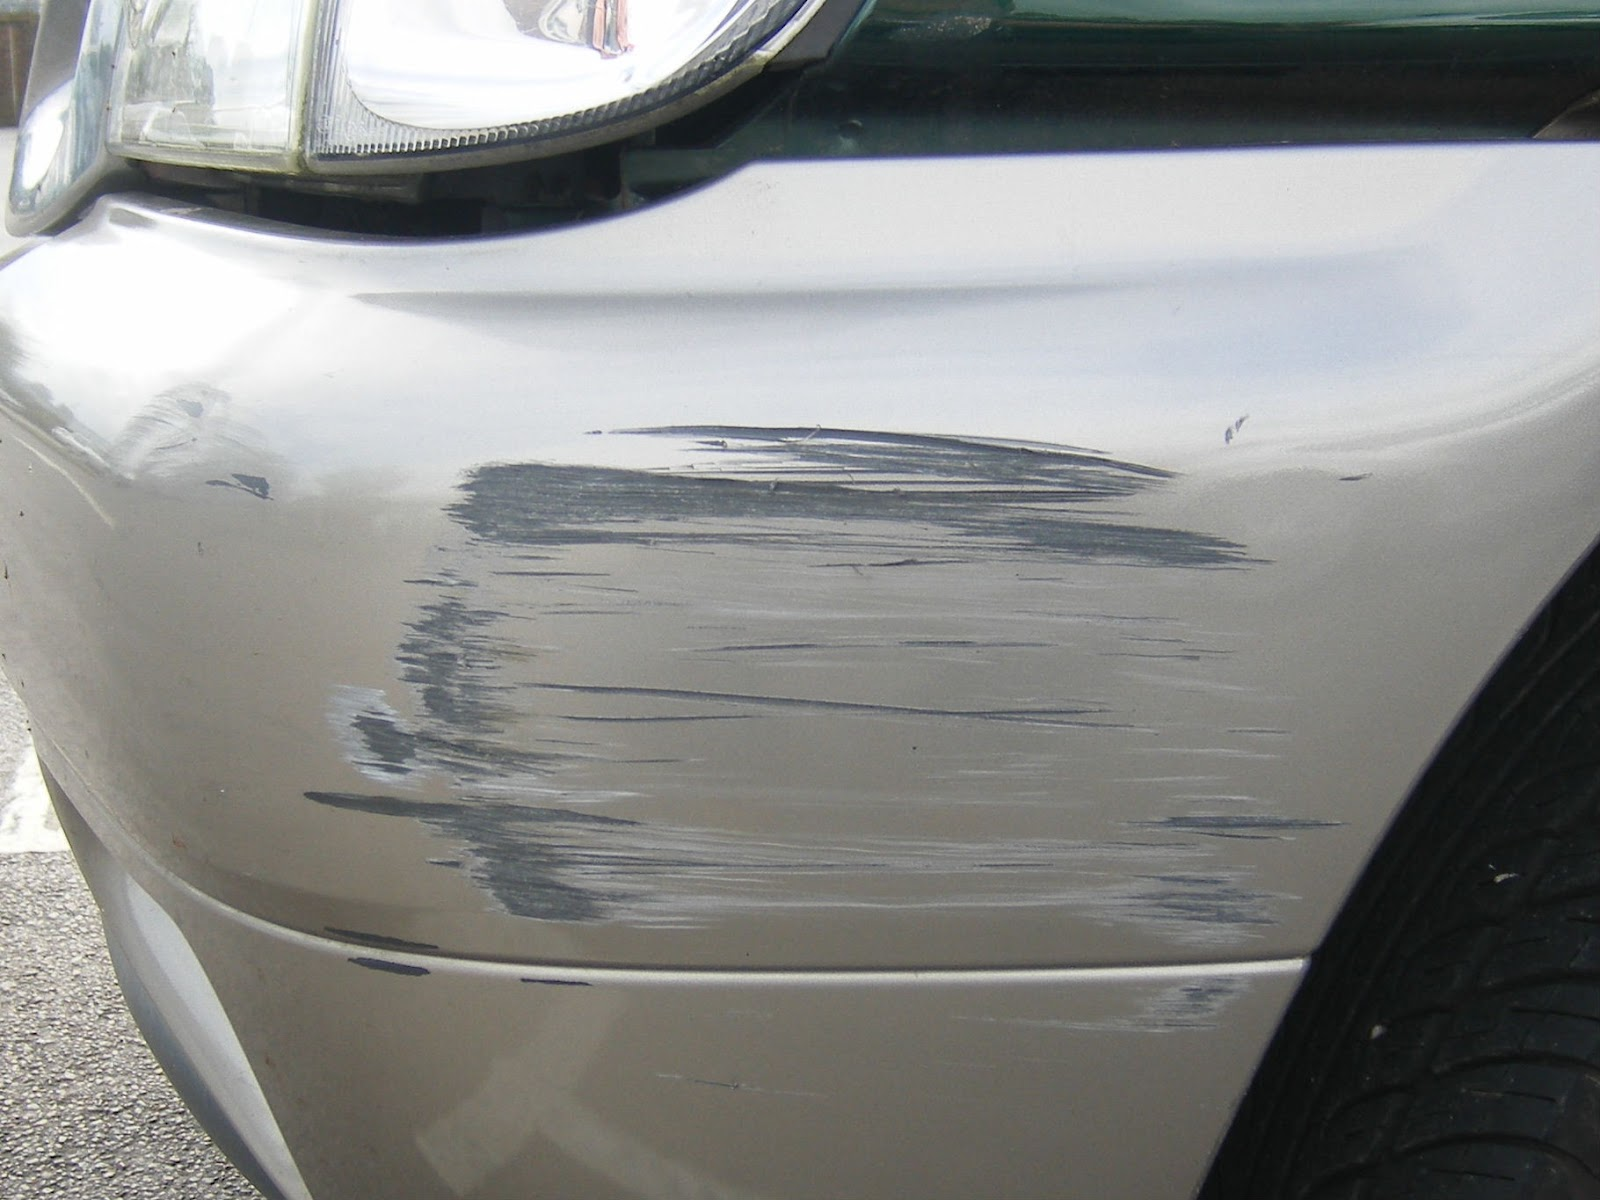

In [ ]:
Image('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG')

In [ ]:
pipe2('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG', ft_model)

1/1 [==============================] - 3s 3s/step
Validating that damage exists....
[[0.05892709]]
Damaged


In [ ]:
pipe2("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgKCgkLDRYPDQwMDRsUFRAWIB0iIiAdHx8kKDQsJCYxJx8fLT0tMTU3Ojo6Iys/RD84QzQ5OjcBCgoKDQwNGg8PGjclHyU3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3N//AABEIAHYAqwMBEQACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAABQMEAQIGBwj/xABAEAABAwMCAwQGBwYFBQAAAAABAgMEAAUREiEGMUETUXGBFCIyYZGhB0JSscHR8CMzQ2KC4RVEU3KSFiQ0k6L/xAAaAQEAAwEBAQAAAAAAAAAAAAAAAQIDBAUG/8QANREAAgECBAIHBgYDAQAAAAAAAAECAxEEEiExBUETMlFhgZGhFBUicdHwI0JSscHhBmKCM//aAAwDAQACEQMRAD8A9xoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoAoCJ+Q0wnU8tKB3qNC0Yyk7RQik8a2GK/2L83SonGezVjPcTjbzqnSRvZPU6XgMRGKnKNk+eljdXGNkTzlY8U4oqkWXfDsRHey8TA4ysR/wA82PFQq2ZFHg6i5rzJkcVWVz2Z7P8AzFLlHhai7PMts3i3v/upbSvA1JR0Ki5FtLza/YUk+BoZuLW6Nwc0IM0AUAUAUAUAUAUAUAUAUAUAUAUAkul8DEsW+CA9NUMqz7DKftL/AC67VZK5FzyjiWRc7lxaqALm84GihtZaUUJ7RXMYB6Aj4+6rpLkQ5XWpX4ntiW4rkV2W7MkRdPaOujcNL2AJzlWFY8NdcONjly1Y7o+i/wAfqKr0mBqdWadvn3eH7FLhTgWPxDGdWxMLDzCglxC2ARk8iCDy2PwrujZq589Up9HNwa1WnkQ8S8JHh55tlybGkOrGS22khaB0JHQHxqxUUIgAglSQE4JBP1sY2Hed6AY2GwxbrKehKSpMlxhZiHAwXQNQB9xAI+FQ9ArHZfRnbrPdYTsOSmRHuMc68tSVo7RHfpzjIOxGO7vqsroupNbM75ti8WpI9Fkm4x082ZBCXcfyrAwfA4qHZi/aMbVeYlyK0NKU3Ib/AHsd0aXGz7x+NUJtzGORQgzQBQBQBQBQBQBQBQBQBQFC5T0RmFYcSlwpOnbOD34qdtWbUqE6r0R5o5IkWtD76bkpTivWcUmPknPtEcz/AGAqrxEEjrXCa8tdLHFwLiIsxxbXbuuqeU4XRqDilk5J3T8q5PaK1+R7Hu3huX81++/8DcOOTHVyUokPMy0OtPuuN4LRCCr1sbD1kJGdq2nNVaDvuedRpPB8RpuGqurPXZ6Faz3uVZO1MGUuOt4BKyhgOZxnHMHHM0w1ekqUVN6o04tw3EzxtSdODcXr6fUqPXCHKfW7IklbzqsqW4lQJJ7yRXT7RRX5jzfdmL/QMp1/buVmhWoxW8w1Hs32wMkYxjSO/bf3VVYiinfMX91Yxrqeq+pXtclFoukae6y8pMdYc0aFI1eeDSWIpW3IXC8Z+j1X1LMS6ob4ncvdsHo6S8XEsuKG4V7STnGxJPyqPaKVrXLe6cZ+j1X1O1i8fudolMm2JUg/WjvglPkefxqrr0uUifdWN/R6onvNytV3Y7aOqXGubKSYshDKgtCsbAlOcp7wdt6qq1N6D3di4a5fVfUi4b4q4idktM3i0p7JekF1BAKe8qGfPaozvNZaousHB025fDJeKfkd0JkdXsvtH+sVpdHA6c1yJgcjIqShmgCgCgCgCgCgCgKtzkiHbZco8mGVuHySTUPYtBXkkzx+3X5y+25u5LlqhxmsBxUhWrUcct998g1g3Jv4tLH0tDoejUqWt+4y676YEi3SYk1ZWkFDawhQGd9lH9dxqjip9VnSq8qfWX35kEy3uNZEqNJbH2ijWP8A5z8wKzlQZ1Qx8XuKUWoJdW9b9D6FH9oyhWPW7wOQNZThNm+HnRg21u+ZhxcdGy2loP3Vg3FHfFVHsyBehwYQdQ7j+VU+Rp3SRTWy0D+6SMdwApmfMOnDkh3bOI2o8cRJcNBaGwcaSNXiR18sVvCuksskcFbBScs9OWveMm5TpbL9omOFAHrJaVnT4oPKtMz3gzFxg3lrx17/AKmE8VXFk6X0oeSOqRg/Co9pmty0uGUJax0LTXGGr+E2T1BQKusV3GD4VHtJ08WM/Wisf+sVPtK7Cj4XL9T8yU8Uw3EFDkdIB7jip9og1Zop7rqp3jIZQOJW5elhia6w+B+zUTscdCDsa0hWjLS9jjr8NlT+KULoni8eOQJSY1/jjs1HCZcf2T/uT0osS4u014mVXgSqw6TCy8H9Ts4FzhXBvVDkIdGM4B3HlXTGcZbM8Kth6tF2qRsXKsYhQBQBQBQCrilpT/DV2aR7S4boT46DQlbng3FVpeh3Ny2QGVp0NpWGdWVHbc479zyrnxMbtM9nhFR5ZwXzORWt9hZaeQpCgd0qGMeRrncUz1FOURrbeKbrB0oZmu9mOTazqT8D+FSnOOzJThJ6ofK41Q9HU5KgNekpThLrZ0+Xf79jU9I5aNalrRppzvojn2LzdHZokXOI87HUcqKk4OPcOlWnhsyucWG4241MtrR+9zuZ1qtLNmauLDjzrbpT2YbUElQIzzOcbDu51hKhSik2z14Y/FzbjBK6V9f6F1o/wS9zFwWZUmNJCO0QJbaCFjqApKtyO7SK2eCXJnmQ/wAjkn+JTt8v7+pak8KONbqlRNPMFS1Ng+a0pHzrN4OR2Q/yDCy3uvD6XKC7RJirDiUq1JOQ40rVjwUmqezzi9jpjxfCVFbOvH+zC3FO57fdZ/iAb+ffVZQfNGsMTS/JJW+ZReThQHXpismtTrU7o11r6mmUZ0YLhHtLSPFQplZV1ordmqpLLe7kplHvLgFSqcnsijxVGO8l5okN7juDsnJ7D2rbTrCifhWnQ1XyOf2/Bwd+kXmMYF2kQWRLaUpLLKjpcWFI04x4E8xW1KjUzLNoebxDieFdKSp/E32LTxPaeCr0u/8ADcS4PoQiQoKQ+lHshxJKVYz0yDXoHyI8oAoAoAoCrdE6rbLGNWWV7HrsaA+ePpIksC8pcg6m1KWXAtCzjYYBTnfHce4iq1ldHXgajhVvYWs35ie0mNf44d07JkNjC0/D9e41xs+ihVUuv5la4WNTTXpVveTLiYzqR7SfEfj91RctKlzjqiThi2Luc5toPpjpUsJMhxOpLWeRx1PPwAJ6VvRh+Y8biGIa/CXid7cuFLTZblKhzY8h9tuK063L9JWFurUpSVbAhIwQnbB5711JJ3PIZyfpU1qyQe3bcbhSkqkRkuEH1clJ32zuPdseW9eZiYtStyPsuDV1UoN/mWnhyFUF1uPPYkvOltuOpZKkpB9VaQCPv766adVqmmeNisHGeNqRcsqtm7ez+Tq7VdrAw4HIl0OSMKQp4DPkQn5GtemXYzn93uXVqR8xuZEOaoLjHt3NsBehQ2/m1bfGir02xLheKSvZP5MSXiPeIq1qejPtsg5DoOpKR3ApykeeawxGIlBfCvE9HhnBaVeSdeaX+q3+/lc5u4cQqjIXHUsSSoYU0tCSnzOP7+FVodNP4pbfIcThw3DN08Pdz7paL9/QTi9oAwLXCKRyBbSceZBNdWU8PpO71NhfykYbtluTv/oD8MVKXeUck/yr1+of9SzgP2TUNo9C3HGR8SaW7yc/Yl9/O5G5xFeXBgz3EjuSEp+4UyonpJfaRb4ZNyvXEUK2of1qluhsh7dIHUnwGeVUnSjJG9DG1aDdtU909mvkfQv0ZSAYFxgam1KhS+zKm+SvUTvv7wailezTL8QcXUUoqyaWnZ3eB2danCFAFAFARvZ7NQAySMYoD5h+kNm4o4lcSIH7GMkMpLRKkLA21Z6EjHhioklLRmlKpKnLNERIbLjersnEd6VDf49axlT7DvpY1X10/b+iWHJkwndcZ1SDnfBwD4isJRaPVo1tdHqddb3rYeE5SblpadmPrUFIGEIQEpRpVjlklRB955bV2UrZEeBjJOWIm+86KROek2y2i8xVzZDCE6HEk/t2zqBOOpOlGSNiU52zWiOY4/iGc++puI7sILKGgkDCWsYT2ac8wMc+/oK5cVFNJns8GquFSUe1Cu3Bl6Ywy+kKbddShSTyIOc/fWdJ/DbsaOrHq9VSXOMl5aiFu3S9ZQlGvScZQtJz06GulrsPEozV7SZOqNKjI/aNPtauqmynNZO/M9Ck4rqyGVoujzDnYPvrUhWw1qJ0msZxuj08NiZReWTFN0j9jKUpG7ThKknuPUV00p5ongY7D9DVfY9ilpOOVanGGKA1Kkj6w+NAModju80Aw7VOfSeRRHWQfPGKA7Hh2wJ4WacvnEM0QJyEkQYTawp5ROylLSPZGPv8KrKVttzalTzO8urzO5+gaQ68i9l8EF1xD/8AyK/yqIrLJo0ryz0o1HveX8P+T1yrnKFAFAFAYV7JPuoDzDiO2ntEq7LdSTqSB3Hn+u6jJSucNd7Eh5BLXqnPIVAOUlw5ERWFJJA+IqGk9y8KkobHZcJzrcng+Wu5WRV09FkLCGlFKUDWlKhnrnKFDlipStGxWpLPNy7RJYbgwnTcQxDhBbrjkeCFOHKOWSc4SjUrGw3IJwakqRSYy5EqSIbiWmmm1Ieh5wUpSDpUnOdSRt7xis6/UZ28PlbExXbdegtihaFFwDCkJ7RJO4yOVcSm47H0k6CqRzPkn6qwqfMCXKdkNIfYDyyvQtAWlOTnGoEHHlXfJra58tRjLfLdD21PW/QUPyBFz/EhPrZPmlQANZWnykd6lh7fiU34E06zxpKguPxDHknGyX3gXAPInNJRn8y8KmFtZNrwF7kB+NnD0aQk7FB9YK8RVVmT2LzdKcNakWjdt9lsZVw7BWrqpwuBPzcFbfHzPMccPybJWr8hoZatHDbKhyJYQsj4rVU/EZ3o9jJhxtemdmLvEipPSHFQgjwKW/xpaXaS50ltEXTuKZ05KkzrtdpQP1VukA+RUR8qZR07XVSQtZmDVoYiagr2io61eQAA+VQ4pal6dac5ZHdp8lue3fQctPb3TU24l5bbRJXtkDIG3SsMPJucru56nFqMKeHpOEcu++j2PXa6jwQoAoAoDB5UBzb4DsphbqPV0FQIO52xUM0pp5vhEN4sSV5diAA8y2PwqDSdPsOPuNuQ4FJdb394qTAUQFJ4flSFOoWu3y2i1JSjmnfKFjPVJHwJqUQJb9aZbsuZcGf+4iuQMJKU40adIKceRIPdUsFJhPp/+D3YuoSQn0Z5JOFFaMJB94KSnJ7wazqK8GdGFnkrwl3mbQ1puCGJCuzS4nQVfrwrhmrH1WElmdmu4eRfo9kOLKWJkcp+qVA7/AGtHmmZKhRw/Jm1z4MkW/HaqZVt9QK/EVlNThudtD2at1UJX4TUcHEbtV/Z5DzJrKM5N2crG9XD06cfgpZn4L92J5VumSnCp0RmkjknWAAK7YVqUFZXfgfOYnh+OrzzTUY910kiIWhtP724QG/69Rq/T32i/I5PdluvWgv+rm3oNta3cumr3NME/OnSVHtD1HseEj18QvCLZulq0g4S1Pk+GEin477F6k24bB/nl5ImR2af3FoaQftPulRPkadHUfWn5ELF4WH/AJ4df9Nv02HVmsV4u7iUNSosJpXMjCR8gTRUIc9fmRLiuJatBqK/1SX9ntX0bcDxeFW5EoTnJ0yUkJccOQlKRvgDJ69T8q2SS2PPnOU3eTuzuqkqFAFAFAFAc+plbchxCk4S2pWknqCc1WRvRXxXNVpPnVbnVZNCy5WxmYDrGlfRQFSmZTpX+/u5yF3sLiMocQSk7Z6EVY5pQa3OWVb+IrOkps81Xo+oLEdzdKTvuAoEZ3qblDlLtFv0p9Ts1palk5KtQPwxsB7hRhO2qKSxc0NpQtxzQhWpO+6T3g1Rwi+R0xxdaO0iZu8XtjAbuMxA6aXTUKnFGr4jiHvIjkXa7SP/ACLnPc9xkK/OpyR7Cjxtd7Sa+Wn7FQlSt3VPL/3LqVFLYxlWqS60m/EEpjj/ACqj4uf2qxmbhSB7ERn+oqV+IoLstRn9LiCuKhSRnWEgJznOCDg4xt38qgg2bTKcIyVKGclOcDwoSX2rQ6vS62k6Vk7dU0B2PCdrLLwTLUptGQQoDOnxoD2uxRmmIqVMvpdSR7STmpIGlAFAFAFAFAVZrSinW2nUocx3ioZpTnl0KRbBqh05iJxjHSli6lcoy4xWnfdCNzk1aKOatLWyFTsYuvO6UJ7PsiWxp8N6sYCmZYe0a7ZLeATg92agCOVw2XQcChIkk8IvlR0oBFAUV8Hyv9OgNRwdKP8ADoCVvgt4ncUBcZ4KP16AYMcHspxqBNAMo/DcZvk0KAZMWlpGAlA+FAMmLXgZUAhPefwoDqeHGezQ4WwdAATk9TUhjyhAUAUAUAUAUBVktaQXEg+8DeoaNIT5MhSApII5GoNbkTyEJZdK05H9qsjCe5Sixg6lSW9wkHA6pB5ihU1VEUXgkewhOlIPXvoCg9CKFEFOcd1Rcu4NEJijuoVNPQwfq0Bj0IfZoDPoP8tAbCD34HjQG4hIHM/AUBKiKgbBsqP67qCxYEVaB62lodx2P50JsHZNg5ypw9TyH50J0H1rTpiDIxk8qIibuy5UlQoAoAoAoAoANAU3EhLqkgYGM1BrGV9DGdIUcA7ZweX63qUUnuRslzdwqA30hIGwFCodh2mh3WQSMkUJW4FhDySVjJ2AqDZuzsVjGb1EDI86i5bIjRyInmFfEUuR0ZH6JnkoUuR0Zt6IEjK3MD3JzUmbViIejAkBLij78J/OhW5nWhPsMN/1etQXAOOrOkL0g9E+qPlQGyYv2lUuWUbkyWG0J9Ub95qLl1BDdhOllI91WMWSUAUAUB//2Q==",ft_model)

1/1 [==============================] - 1s 750ms/step
Validating that damage exists....
[[0.9936347]]
Not Damaged.


LOCATION OF THE DAMAGE




In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1, ', val_acc:', model_hist['val_acc'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0]*(400) + [1]*(288) + [2]*(272))
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0]*(70) + [1]*(50) + [2]*(40))
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')

    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
    model.save_weights('/content/car-damage-dataset/data2'+'/ft_model.h5')
    model.save_weights('/content/car-damage-dataset/data2'+'/top_model_weights.h5')
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model,fit.history

In [ ]:
def finetune_categorical_model():
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path)

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)

    predictions = model.predict_generator(generator, len(labels))

    pred_labels = [0 if i<0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [ ]:
location = '/content/car-damage-dataset/data2'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'
model1 = location+'/bottleneck_fc_model.h5'
train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 976
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 176

img_width, img_height = 256,256
epochs = 1
batch_size = 40

In [ ]:
save_bottleneck_features()


Found 985 images belonging to 3 classes.


<ipython-input-70-1a9ae3048da1>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)


Found 179 images belonging to 3 classes.


<ipython-input-70-1a9ae3048da1>:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)


In [ ]:
d3_model, d3_history = train_categorical_model()

24/24 [==============================] - ETA: 0s - loss: 6.7739 - accuracy: 0.3771

24/24 [==============================] - 4s 141ms/step - loss: 6.7739 - accuracy: 0.3771 - val_loss: 1.0291 - val_accuracy: 0.5375


In [ ]:
ft_model2, ft_history = finetune_categorical_model()

Model loaded.


Found 985 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


<ipython-input-98-f2c26df80566>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])


24/24 [==============================] - ETA: 0s - loss: 1.0123 - accuracy: 0.5164 

24/24 [==============================] - 1016s 42s/step - loss: 1.0123 - accuracy: 0.5164 - val_loss: 1.0220 - val_accuracy: 0.5437


In [ ]:
def pipe31(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)/255
    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'Front', 1:'Rear', 2:'Side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating location of damage....Result:",d[key])
    print("Severity assessment complete.")

In [ ]:
pipe31("http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG",ft_model2)

1/1 [==============================] - 1s 731ms/step
Validating location of damage....Result: Side
Severity assessment complete.


In [ ]:
def final(image_path):
  val = pipe1(image_path , categ_list)
  print(val)
  if val == "Successful. Proceeding to damage assessment..." :
    val2 = pipe2(image_path , ft_model)
    print(val2)
    if val2=='Damaged':
      print(pipe31(image_path , ft_model2))

In [ ]:
final("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgKCgkLDRYPDQwMDRsUFRAWIB0iIiAdHx8kKDQsJCYxJx8fLT0tMTU3Ojo6Iys/RD84QzQ5OjcBCgoKDQwNGg8PGjclHyU3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3N//AABEIAHwA1AMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAAAQMEBQYHAgj/xABGEAABAwMBBQUEBQkFCQEAAAABAAIDBAUREgYhMUFRExQiYYEycZGhBxUWUtEjM0JDU1SxwfAkYoKTojQ1RGNyg5LC4Qj/xAAaAQEAAwEBAQAAAAAAAAAAAAAAAQIDBAUG/8QALREAAgIABAIKAQUAAAAAAAAAAAECAwQREiETMQUUIkFRYYGR0fChFUJTcfH/2gAMAwEAAhEDEQA/AO4oiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAixF02jtVsqDT1VWBUNaHGCNpe/B4HSASsY/bWnc3VTWq6TjGciEMH+ohVckjaFFk90jachTlabNtTdp4j3GxujeQdDqiobuPIlo4/FWFZtjeKNwhq47XBLpycvc4/AcFGtF+qWJdrJeqOgZClcok+kCvLji5UDMO0+Clkdg+/K9N21uchLWXYOI49jQ5x8VOb8GRwEuc199DquUXKXbTXp5w27XFv/AEW1n82Kzq9tbjb5WR1d+uLHSDLe0tsQ54+6EzfgOBH+Rfn4OxKMjquVs2xvGgOju4IP6U9ryD6tcAq8G3t1YWtL7LVkHe0yvp3H3agQmryI4GfKSfr8nTlGQtIpPpGoY5GRX631lpc7hLK3tID7pG7luNJV01ZTsqKSeKeF4yySJ4c1w8iFKaZnOuUHlJFdERSUCIiAIiIAiIgCIiAIiIAiIgC8k4CiaWOGJ8kr2sjY0uc5xwGgcSSuYbabctucTrds3VSlriWy1NNh2tpBBa3AJHHiMKspKPM2ow9l8tMEa79Jt+O017FosVM2eOB2mWeNgLpnjdjVya3fz3nPRZXY7ZCntTW1Vy01FYRubxZF7hzPmrSwUV2o6RkNDb9EYAyXU4YT5knBK2KBm0Y408P+IN/FZ8TPuPThgVVvKSb/ALMrPoFPIKOOFk+g6CWjAdjdn1XLb3HXUcsj7gyTtXHc928OJ4YPBdFc6/MYXOpKI8vEePwKovgu82RUUtteCMBrpThvzVlPIzuw3E5SXuaVIy2wbJsp6QsluU8jO0c9viYdQJxnlyz5reIaOKglo4oWtA0GIkDGogA5/wBJWKq9mpqoOxbLdG484axzP5FV22/aVpj3wSCN2puqracHBHEszzPNX4iOR4Sxd69zN+uFzz6U26n0LgPYDt+OvL5LctO0nO307j1FS0/gsLtBs/e72xrZ6Qs0eyI9BA+MinWinVrPrXyNhK/vtibC85kpnaOPLiFmKqjgqGls0EbweTmgrXNmtn73Yp5pI6ConbICx8emMDcdx/OH+itgM15G52z9SPc/8AVGpEdXsX+oxE9llp2O+qqgwtPtU0o7SGTyLTwVja7lUWeuDKN/1NVZyaaVxNJUe4n2c+o9y2E1da387ZK5vm2Nzv8A1WAvsEtw8U1HUgseezbJTSBobgbj4eoUNxe5pCF0dstvc6Fs/tpBWzihu0X1fcAB4JD4JPNp8/X3lbXnovnZm0LauuprVdbeyOGN2GSR5a+FvMA54YHNbZR7YXWzRspaCvoLrTA+F1a90T429DgHPz9OCorPE1ng3LerfyOvIucwbeXYgl9LZ5vKKsez5lpWRpduKh4/tNnDT0p6xsn8Q1TxI58zN4HEJZ6TdUWAh2opHAGeCohB5uaCPkc/JZKlutDVHENVGXfdJ0n4Her6kc7qnHmi+RRqHVMhSUJREQBERAFClQUBrP0i9o7ZGuii0l0rRGA44ByeBXzzZK2ptlU4MqZICcs1RPwM+eOIXZ/pkvgt1ohogwl9S7UHdMLg2rJJ5krltl2j3ejaVwtUu82ua73d0gaLjUjJ34lIV/T1dIyPN22oqI3n9XCHyu9cbh8VpNbcniOOGDJe4YA5kqpbbDLXvYJS6R0jtLdUojjDumefoEhW5bs1xeNrq7KWb9DbaqsskkTu5bTXDtRvDJ4HAO9QThW1FWBr3x1PZVhIPZl4aRnrnBJ57isVWbLimia90UI1SuhaaepOovaSHABwGcYPBYpslRapgQ8yRatOpzcFp6OHJWdTW6MKekK59izYzlVXdi85jwejSWj4BW/1wRwa4e6R34qxnqDVEOx4lbujkH6LvgsHzPX2SMv9eTfoh/8AnO/FR9d1h9kvH/ed+KwxcRuKjWU3K6o+Bn6W51skrg+rmiBOSWSEn5uA5K/fcLpC4Cj2gq/MvkIHp4itR7Q9SmvzKncz7LeZuL73tFI3RJtNWhv9yYt/gVQfU3KUYmv9ykHPNW8/zWrdoeRPxUiV4/SPxTNkqNfgbAyhhLtZqJS88Xa95VQUEDSdHjfpONTid+78Vr7amRvB5Vdtwkbg5O5QX5cmZmhhpO8tZcGuY3O/TuXQKak+jmno2zVdSwHGS2SZ+v0aN59FyetupNN4xvzu5/BUKe3y1eZKpz8BuoxscAGjq5x3Ba1Rb7jgx2JhBZNvPyOjXS8bGR/7lqKhp5aXzx/NYX6ync0y0VwqSG7wJX9pj14j4rFSbJBsLpHQUoayFs5xWu1Bjs4OSNPI81hp4au0yF0MkpaBlzH+00dehCtOlvdGGH6Srj2Zr1zOh2T6QbnQOENVUvBHBzvyjD7wd/rlb5afpJon3CK3XuIUk8oBinY7XFJkZG8ezx5rgjqhtQ1srAATxwszZbrLS0pETwJPzOojJLHbiFSFjjszqxWEruSlDI+n2HK9LxH7A9y9rrPmwiIgChSiA43/APoCGZn1VVZJpyXRHo1/EfEZ+C5DEQ57WkgAuAJ6L6xvtloL9bJ7ddIBNTTDeM4IPIg8iOq5NcvoIj1E2u/ysZybVQh5Hq3H8FlOrU8zvw+OdMNGRzCyUIuO0BiaC5rpez8PHSBk488D5rbKnZo1V3FXbalzpqcB1PbqgdhI3Tv8BOGuxj/6prtiZ9hblbZLhXRVEFdLJDJNE0gQktwCd+eDi7/CU2cslyprm6a9V1S0QOc2GnMhLpiNxJJ9lg5nid2FolksjinLVJyZd3y01V5lgilFI2ijLpZp3u0iIngepJ37hvzjhlYfaayspLbE9jqqYMxDLPUNDe1z7PmSMYzjotjpXW27264w01TNR5n0MqM535GklufYfgjkRjzWpXYV9NTVIuZka6WZscEb3k+FgJc9v90lwHp5FSVNapJXRtOlxDmOLcq9iuM7HZOl/k8KwMM0Mxa+M5lOpoG/+iqohn/Yy/8AgsJVNvY9inHwjWlLmbFQbTUkLdNds9b6sddT2H+JHyV+3aTZOUf2nZMsP/Jqz/MLTxBOf1cn+UfxU92qOTD6scEVckWeNpb5v8m2PuWw0r3E2e6w5xjs52HHxVvI7Y1++J93jPIPijd/Ahaz3eq5Qk+eCnYVX7A/AqOHLwCxtS/czLSiy7+xlqCOWqLH8HK1f3Eey559CFZ93q/2BTsKv9gVXgyNV0jV9RcyNpNGWTO1dC1W+RlQYKofqCnZVA3ugd6JwpE/qFL7zwz8pWDmIxqDepW91Oy8dRBBSdtLBUtG+GpAENRL17QbsnOBqPLktJZTy00omc6M9o0EBucsPQ5A3+7K3C3W24VV/wC9zXGop7OZBUskbIXeFxyGMad2c+Hyx7l0RWSPEvs4ljkZaW3XWuszLc+Cn7Z7GRTRmUMEbW7/ABO4Yz038cZWLds02is1TSCpmrp6culjnERbFGBxaHH2gR0WwGottReK+ha2pik7IajDJqcGkYOjPtObqbkHj8Ma62hq7YLnX1ta+a3tgLaRwkcY5i8YaQM4zxPlgqxkaXSt0TSwtzpBy0dAVlqCKAxztqO8FwYXsEDQTkb9+eSp2zZfaO51lV9V2mql7Mta/cG6ctyM6scRvW+7O/Q/fKqaCe/1UFHTBwe6Bn5SVw5g48LfiVjKrOWZ6lPSCrp0NbnYtk5aufZq1zXEAVclLG6UAY8RassvETGxtDGANa0ABo4AL2tjywiIgCIiApzdpp/J8VgblHcXA6NXoth96t56kMBEY1O+QQHLtprLcLjRyQVcT3Ru35PI8iFpPeq2zsNFdKWSen7N0TZ6fdK1p5aiCPQj1Xc5YTO8ulJcSvUdtaQcgDdnHMoDgTb1b6OOdtFTXCqklGlzKrBZp6ENGSsVPS3S7VLqielnc528DQQB0A8gvpFtuZJnAc3AySVRfbmMOHMx70B8+s2fue7FNK5uOJbvaVH2buvKklx7l9AdwZyao7iz7qA4D9mrsf8Ag5fgp+zV2/dJV33uLPup3Bn3UBwL7NXb90lT7NXb91lXfe4R/dTuEf3fkgOBfZq7fukqfZm7fus3wXfe4M+6ncI/uoDgJ2au4H+yTKfs1dGjJpZCemF33uLPuqe4Mx7KA+ep7BdAPHSynPIA4Cq2yvuVlLWzUT5IWvDw18Z8Lt+9vQ719AigZ91VorWxxzjA6lAcHiu9piqjVw092fOHFzY3Pbp1eeBkjepjpq+/VUUlVTiGnj/NwMjLW8eJ/Fd6bboy/RpIPUleX28M5buRHNAadZae9M0uDX45EcFu1sNeGgTNPDmvEMJhOYiWHnjmsjT1BcdEnHr1QFwzOneMFekRAEREAREQFKbJGkKh2JV08KEBbMi8WCqjNYIDskZ49FUA35U4/ooCmG6QdIPHgea8PYX51Doq5RwyEBatg1ZU93HVXLRgKcISWvdx1U93HVXOE3IC27sOqd3HVXO5NyAtu7t6p3dvVXPoiAt+7t80FO3zVdMHqgZa9l4iMKo1r2uwG7j5qqRvU8kIPGkaieJ4Ly5rnOOr2VWxuUHgQgLYRZzjkvTIxjOFWDdylrUB6bwHuUoiAIiIAiIgIKKUQEIpRAQilEBCKUQEIpRAQilEBCKUQEIpRAQilEBCKUQEBFKIAiIgCIiA/9k=")

1/1 [==============================] - 1s 1s/step
Ensuring entered picture is a car...
('n03100240', 'convertible')
Successful. Proceeding to damage assessment...
1/1 [==============================] - 2s 2s/step
Validating that damage exists....
[[0.33975095 0.30190718 0.3583418 ]]
Damaged
1/1 [==============================] - 2s 2s/step
Validating location of damage....Result: Side
Severity assessment complete.
None


In [ ]:
final("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQmgrebNaUJRPnB11pFU8jArMf7_Q0_DNoZzA&usqp=CAU")

1/1 [==============================] - 1s 603ms/step
Ensuring entered picture is a car...
('n03417042', 'garbage_truck')
Successful. Proceeding to damage assessment...
1/1 [==============================] - 1s 719ms/step
Validating that damage exists....
[[0.5362789  0.24605705 0.21766405]]
Not Damaged


In [ ]:
final("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUWFRgVFRYYGBgYGBoYGBkaGRgYGBoYGhgaGhgaGhgcIS4lHB4rIRgYJjgmKy8xNTU1HCQ7QDs0Py40NTEBDAwMEA8QHxISHzQhJCc1NDQ0NDQ0NDQ0NDQ0NDQ0NDE0NDQ0NDQ0NDQ0NDQ0NDQ0NDE0NDQ0NDQ0PzE0PzQ/Mf/AABEIAK8BIAMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAAAQQFBgcDAgj/xABBEAACAQICBwUFBQcEAgMBAAABAgADEQQhBRIxQVFhcQYigZGhEzKxwfAHQmLR4RQjUnKCkvGissLSJFMzQ5MW/8QAGAEBAAMBAAAAAAAAAAAAAAAAAAIDBAH/xAAiEQEBAAIDAAIDAAMAAAAAAAAAAQIRAyExEiIyQVETcYH/2gAMAwEAAhEDEQA/ANchCEAhCEAvCJFgEJVu0/bfD4MlM6tUbUU2C3FxruQQvSxPKUPE/ajjGbuJRQfw6rOfFic/ISPyjsxtbLCYmftK0hf/AOn/APM/9s/hODfaPpEG5q0/5fZJq/n6x8o78a3OEx3C/axiVsHw9J+jOl+mTW9Ze+y/bXD406q3p1LX9mxGdtuow94DoDynZlHLLFnhCE64IQhAIQhAIQhAIQhAIQgIBCEIBCEIAIQhAIQhAIQhAIQEDAIQhAIQhAJSu0v2gYekHo4dxUxAuq6oLIj7Ls/unV3gE55G0b/ax2gbD4ZaFJ9WpiCVZh7y0gO+RwJJC34FrZzFMApvlluvwHykcrpLHHaUxOszFnYs7MSxJuSxzJY8TeNwl/rcNvyE7OAEub2uchnc5b43p1b7fBeJGy/IW+MrW6ddb+E2yvfZYTi4BzYnZlxnPE4lr2GQtfyF/wA5xFMtne/Lb8NphylvY5bOck8BrqVdTqlSCpBzBByPIxk2H1QOufKPtHtnqnZFp8W/9mdJftOGp1Se8Vs+7vrk2XPb4yVma/ZrpcJVfCMRZwXp7u8PeUdVz/oPGaVLMbuKspqiEISTghCEAhCEAhCAgEISr9tO0/7KmqljVYZXzCD+IjeeA+jy3Tsm09jtIUqK61V1QbrnM222UZnwkHV7b4RRfWYjkrBjzAIzHiJkQ0kXcvWd3c7STfzv/gbhHaVqJ5k7feb1AEqy5Ktx45+2iH7R8Ne2pUtxsvwvJXR/a/CVSAtTVJ3ONX12TIq2FU5qp9fgTG6ADKxB+t35Xkf8lS/x4voNWBzGY4xZj2gO1NbDEC+vTv3lJy/pP3TNV0XpKniKYqU2up2jep3qw3GW45zJVlhcTyEISaAhCBgEIGEAhCEAhCcsTU1Ed/4VZvIEwMW7c1P2nGOb3VD7NOS07hvNtY+IjrQPZZAus4uxz6DhGuhKYesC2ZC53zzOZJ53+cvWEQbpkyytrZhjJFexXZim2y4HKMj2NXarchlytL37OC0wJztK2M3rdjGPEzi3ZJ0Hd2nLLpNRRBPXslne3N4sk/8A5Z755+Nvr9J4q6HemM/rhNXrYFTYgbJG4rR4Pdbn5ETltjvxxrP+yuPQY2g7EDVqKN9rMdUnlYE+s3ufPuKwIV3uPdY2I2rn7w6HIjhabvorEa9Ck52vTRj1KAn1mjC7ZeSap3CEJYrEIQgEIQgEIQgNNKY5aFJ6rbEFwOLHJV8SRML7RVqlWszVDdmOsR12C3p0Amndv8XqoiDjrkc8wt+Q758JRtG6O9tUyztmTxPXgPrZKMsvsvww3P8AasYPAVnawRjntF7Sx0NF1F99L24Zkf8ALyv0miaN0ciCygX3m2ceVcCpGYErytyXY4zH1nD4WwuLniN/9J39DGOKoA22EHY3PgeB5S84/Q17lT+fnKxpLAMt7jbt5yvdnqdx2glQg29N/hH2gNPPg6odblGNnTcV5cCN3+Y0Vz7jZjcT7w6nf1jbEHcf8/rJ43tXlNxvuFxSVEWoh1kdQynkfnO8z77LNJko+GY5oddP5W2gcrj15zQZqxy3NsuWOroQhCSREIQgEDCEAjXSiFqNUKLk06gA4koQI6gR5QMP7LYoNVy+8uXQfpaaDgpnOh8C2G0lUw7Zajuq80ILIRf8JWXirjWQHUR3bgAQB1My5TWTbx3eKbE5kGVev2qqp72Gc9MxfmQMhHWju06VLB1ZGOVm/O07+ixYFBnRFMb+1G3daQ+l+1SUAdVGcg22ZX6zvR8asuoYzxK5yvaM7XVKwyoG97ZMLctslEx5fusjo3MHVy/FsnMo7jKz7tJUCVagA2X8b2/WbRoelqYeil76tJBfjZFmM6R0a2J0kKCg9+oA/JNQMx8FBM3JFAAA2AWHQbJbxzpl5b9tFhCEsViEIQCELQgEITy7WBPAX8oGU/aLpG9YoDsIXwAsbeJbznbsBTJRnP3mPpKt2txJeq779YgfzE/qJfNFYJqdFKaOtMKo1mI1iW2mw2bb5mZPe/62YTX/ABZqAjlxlKZUxeJQ/ucSjj+F1UeRWT+jcfUdf3ihW3hTcdRJTUjtltOai5SJ0hhQwNxJSviAu2VjH6fqF9SnQLC9tdmCr16SFm0pdKpprBMhLLukM7h0Db9tum0fXKXbSCV3Qs6UiLZhHOsOlxYmZ5iSadVgPdNmt1y+Vp2YoZVP9ltJ/s+JSpfu+6/HUbf4GzdVm503BAO2/DZPmxHtnuB9D+o9ZtHYDTAq0AjHvoAp46v3D/x8BLMMtXSrPHc2t0IQl6gQhAwCEIQCEIQMk0tTIx1Os1tf21SixuSSO/qXvyv6Sy1MMzqQrauWUa9vsGUqUKoHcNdGY/iI9n8wfGSWCN1mbKfbVbsLLNxVNN6LfUp2Z9YN+87xClbm+SgDO4F8yLfejPA6O/fWpkugALawUAmwubA5Z5jL85dMWmt3bXnjD4NEGW0nMzlv6SmMnZ7QpqRs+7KRprRS+1U1NYI1/dt3Ta2Q43+uN8oWt4WnHEYRHBBHSd0S6VLQOi6gRxruQSdRTrMmdveVxkosfdsTfaLZ2ijRZEs3DrO2GpamVrfCLi2yi9zbkmrqKboumWxuMqLkyaiqbsLFhnsIv7gmrUybC+2w87TO+x+GL1cQdXuviGueIp2Hlm3nNGlvHOmfns6ghCFpYoEIQgEIQgEYaaralCo/BD6/5j+QHbR//GK/xuqeG0+gkM7rGpYzeUZGtP2uKoI2wuHboCWHmRNA05od6yaqOV6W8rHL63zOsJjAMejbg4HmdWbDhnvaZvNNmPctUir2WXXpkFwqldcMXaoSAQVVg1tUk32Cx5ZS16NwpRQCSeGta9t17SaCAxpibA2k8t6cw1vURummJYKMr/pK5p7Q7vSTVco5bvjWcaqawII1DZjYEHWv72UndLvZ1O61vGPqagqL5yON1UssdxQKOCqJVK0XdqdgO+Dt32vnbf475DdrsFqujH7wKt1yI9ZqGJpIoJFpnHbvEi6D8RPlb852XeSOWOsVcCauR2EbeR/W8s3Y3SpoV0O4nVbmp5dbESIemGQcCBbxF/jeNME7qbXzU5H1BnUH0mjggEG4IBB5HZFkP2VxgqYamy7ANXpYA6vVQQvhJiaJdzbNZq6EIQnXBCJCAsIQgQnbDANWwlREGs6gOg3lkYNYcyAR4yH0e11B4gGXMSnOmpUdeDtboTcehHnKeWeVo4MvY71TlI5sUFtrtq3Nh45AR7UbKNawJBst/hKmmVJI62OY2TnhsQGBZGDC+0bJE0qL3H0ttwkrQqADV1beVpIsh0dkZY+pqqxOxQSfCOg+U4UU16qIRcFhe+YsMyCOgnPekPl8Za79hsEyYVHdSruC5BFiA7F8xuvreglkhCaZNTTFld3YhCE64IQMIBCEIBKB9pelNQKg+6pc/wAz91B5Bj4y/wAxz7RGZ8Sw5gegtKuW/XSzin22pfuujk2zBJ4XO0/GbPgq+QPECZV2hwIVBbcB8D+Ql97K4v2uGpPfvBQj/wA6d1r+V/GUW7krZxdZWVbKdY2yjPE1HVx3Ge+8WsORipVCi5OQjPEaYX7iO53kK1h42zMS7S+H26NdPaRVrIEYknOw2eccaKd9TvbjlfbbdInE6XFgDScAbSVa/wDtj3B40OusoNuakfGcu3bj8eq9aUxGUyztZWL4hV4Af6m/SaJpWplMy9oKuKZhmA1h0XL45+Mnj/VfLepEhRBCKOHd+BHxMktFYdXTEoQNYUfao28Gk4LAdUd4w2eLfP8AK8c4HEeyq3Owh1YcVqIyN5BifARtXY0X7McTei6ZZMGy46qqSfJfWXeZj9nLGniXpt99CPEZj0HpNOl+F3iz8k1kIQhJoCEIQCEIQCVztDQ1XWoNjd0/zDZ6f7TLHIntEV9mFJAJcaouLmwJNhvtIZzeNTwusor5e4tvkdisALd53YbSNY2vyGyOt+q20bDx3XEctqkDn5TNNtuOWkAqJs13zytqr+VpKYbCMANWo4H8JIYebC4HS0cJh0vsE7GwFheWW3SWXJK9XOpz4yQ0BhyXZz926jqdvp8ZFCpfujM/C+8yxaCW1M/znxyXOOObyZuW/VJQhCaGYQhCAQhCAQhCATKe09NXx7r/AAsrH+1SRNWmR6Rb/wAzFVzsVnUeDao9QJTzeLuH8kLptw+uNwOp5J+ZnDsZpg0XCH3Klrjg+wN4iwPhwjOvUJR2O0sx/wBokbhnswOyzA+Uqxn10vt722zD1757Z6q0Xf3b9QSIwwwJRHXeouNxnYaY1BYhh4X9RIxZLfY44jRrfeJPU/ITi9bUW3CJjNPLbffoZV9KaSdwdXujjv8A0h3LK/tG9rtP6oNNT32yJH3Bv/qkT2ew2QaRGLTWqmWnRKWU8l/zLbNY6iiW5ZdhFuDyIP8AqYTziNit4H66RcIfe+vvGemWwUt7psD5WPwkKlIvPZZQ6Uaq5ulVEfjYmyG/RmHXoJo8yvsG5Sp7NvdqHundr0jrDxtf+4cZqku4vGfl9EIQlqoQhCAQkRpztFh8KP3j3e11RbFz4fdHM2Ey/tF2vxGJuoPs6R+4hzYfjfa3TIcjtgXjtJ27o4e6UbVqgyNj3EP4nHvHkPEiUzRGla2KxXtK76zJTbUUABVDOoIVRs67TvMqrjKP+z2K9niEY5K90b+u2r/rCSOU3jU8LrKNHq0wwsZGVTVS9rON1zYj5HzkorThVSZm3SNTF1v/AFt/cn/aPKJqP7w1B1Bb0yhTU3z2R2qwfF1o0guzbv59TIvTOKrUAcTRcqaZXWW5KOjEKQ6bCQSCDt255yT1pWu2eOC01og5u2s38iG/q2rO47+U0r5NfFb+zHbCniQEqFadb+G9lfnTJ3/h29ZabT54Of19cZZdBdscTh7KW9rTH3HJuB+B9q9DccpqY2xQkJoPtPh8TYI2q++m9g/9O5h09JNwCEIQCEIQATJNN6utU1dj1HfwLHV8MzL9p/tBRooyCopqlSFRSCwJHvED3QBnnwmY4+ofE5n5SjnvkaOGe1XdJGw1enxJPykfTXh9AxxjWu1/xHyzX4ARMMm0cyPK3/WRnUTvdaj2MxgqYZQdq90yVr4RTKd2Cq2DrzvLtrSqrsfEBj8CJDYvCgKZZ8WM+MjMRQLbpx2xmValascpN4VrIfrZPWmMJquSeI+Ubu9lJEst3FMmq8YCtmef/FrH/cY+drgruJHgSfzkJhXta/8AE3kb3/OSuHe4N9oAv1H+PWdpKsegscFpspyei6VkO86hVXA6pq/2zXgQRcbDmOkwVqhH7wDMGzc1IKsOc2PstpFa2GRlYEqoVhfMFchccwAZPiv6Vcs/aYhCEvUGektJ0cOmvWdUG6/vNyVRmx6TPNP/AGgVHumGX2a7NdrFz0GxPU8xKfjcY9Ry7uzsdrMST0z2DkMo3gLUqFmLMSzE3JJJJPEk7Z5AixNWAlpyZdxne05uIFs0Bp/XUU6p74Fg+5xuJ/FxliZ8rzL0Ygy4aC04hUJVYA7idnifzlGeGu41cfLLNVMB87R0hNoy9sl7q6kcQwI850q6WoIO9UXLcDrHyEr1V1yn9OK1TUUuxsALzO9IYo1arO2/IckGwfOSmnO0PtQUpghd7Hf4SERbdZdhjZ3WblzmXUelEIoEQy1Q9K1sxtGYI2i2wiXPs/28qU7JiAaqbA4t7RRzvk462PMyliLA3jR2kaVdA9F1deI2g8GU5qeREdMwGZNgMydgA3kzBNH4+pRfXpOyMN4O0cGGxhyN5Lae7YV8VSSmwCL9/UJtUN8iRuX8OeefCwX3SPbvB0iVVmqsP/WAV/vYhT1W8oenu2eIxBKqxpUzlqISCR+J8i3QWHKVueTAfaIQa9/Dz/wY+0pU1UZuRI6/dA8dXzMj8A9r9QPMRNNYq4AHEHwzI+AmXPvJr4+sUS67uGqPIW+IjrC0tvX5D5meMPTJH9Q9bx+Fsl/xMD5qR84tdkTHYgd9+tpoKU+7My7MaSSjWb2lwrWOsM7dRvHSaRh9I0nA1KiOOTC/ltEjcb6lM54R8LeeKOE4yRDDeQOpAkbj9O4aiDr1UJ/hQ67eS7PGdmG0rnIofbP/AOUqOg+Ehaa3BG36H5x1pfSIru7gEDvEX8bZRthD3rcf1izSuXfaOrJqkdfQ/wCI5w1S3wPMbiZ3x9HIEcf1v8fSMiurbhsPT6El7HPKf0amZU7CPnadsFjqlJg1N2RlOTKbHmp4jLYctkYJc8yPUWtPesL57GGfUDI28Iw6ycz7jWex/bIYgijXstX7jDJXsL2t91+Ww52tslynzvSqMpBBIZSCCDmCDcEHwvNz7M6T/acNTqn3iNV/51Oq3mRfxmllYawiWiwgAiwEIBeIRFEIHFknkLntji0RlgcmPMesFHj5mdQIogIL8J6AiiLAQRYQgeRFAiWhASrstxiWtEZu90E9boHhok9RQIHqg1ieoPpG2J7xA6eoM7K3esNp+X+Z3GGuA4Hhz229Zl5LrJq4+8RRp9wnhY+TEfKcsRV7zruuD6fr6STZQKbHdq3HofmZWamIu7cx6iQ3tZ47lr28vUzspPEHyjXCm58SfOPGQTVh+LJn+TySfoiA1d5HxM9BBwE6LJoG5fusRuPyipUswPC35fKeH91xOCk5HibeYB+JmfL2tWH4xNEBgR5fD5LG/wCzXQjeFPmCIYepYX4fmMvKP1UB1O43Er2nraIRCFDdL/Xh6xGcFb+YGzqI8w63pMOAJ9L/ACnF8Lqgnd+f6Tsve3Mp1pyonIHl8MvymmfZXje7WoE7CtRR1Gq/wTzmZUfujkSf7iP+Ms/YfHeyxtInJXJpN/WLL/rCTVPGS+q+YXiEwUzrj0TEiHbFgLCBgYBFESAgFoCLEgehFnmeoCWhaeokAiGLPLnumA2pN3jO8bYVtvWOBARDPTndEXKeGbImAYMXqX3AWj+hXC2B2MLeIXL5jxjfRlOwZjw+RnPHNkB1PkNWY+S7ybOOaxOsRie5q9R1/S1j4yri+sTwHyjxsQSDf6zN43dbJc7W+f6CMZot2d6NkkRInRrfEyWvNWPjNn+TzaegIRBJIG77SPrZGKk97wI6/Qj6r73lGjDvHpb5/OZ8+smnjv1PsOcuv5R1Rr6yFd4XWHVRqmMMI9gOR+vjHJ7rDgbjwP8AkSq+rHvBPYD65flPeLfuD+Rb9RcRrhTlY7vltnTEPZb8BbxDH9J3H1zK9G9IZnlZR8/W8cJUKlWBsQQQeBBuDG1Ez2TebIx1/9k=")

1/1 [==============================] - 1s 596ms/step
Ensuring entered picture is a car...
The entered image is a not a car. Please try again. Consider a different angle or lighting.
